<a href="https://colab.research.google.com/github/MatteoOnger/NIAC_Project/blob/main/NIAC_PMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NIAC Project: A NS Agent for Pacman Maze**

*   **Authors:** Stefano Capelli, Matteo Onger
*   **Date:** April 2025

**Documentation**:
*   Gymnasium: [website](https://gymnasium.farama.org/)
*   Pacman Maze game: [description](https://www.scallop-lang.org/ssnp24/index.html#section-17:~:text=2%3A%20PacMan%20Agent-,In,-this%20part%2C%20we)
*   Scallop & Scallopy: [paper](https://www.researchgate.net/publication/369945806_Scallop_A_Language_for_Neurosymbolic_Programming), [repository](https://github.com/scallop-lang/scallop), [website](https://www.scallop-lang.org/)


In [1]:
# download project repository
!git clone -b main https://github.com/MatteoOnger/NIAC_Project.git

# download Miniconda
!wget https://repo.anaconda.com/miniconda/Miniconda3-py311_25.1.1-2-Linux-x86_64.sh

# download Scallopy 0.2.4 (Python 3.10)
!wget https://github.com/scallop-lang/scallop/releases/download/0.2.4/scallopy-0.2.4-cp310-cp310-manylinux_2_27_x86_64.whl

Cloning into 'NIAC_Project'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 386 (delta 84), reused 124 (delta 52), pack-reused 215 (from 1)
Receiving objects: 100% (386/386), 4.76 MiB | 32.27 MiB/s, done.
Resolving deltas: 100% (176/176), done.
--2025-05-07 08:32:16--  https://repo.anaconda.com/miniconda/Miniconda3-py311_25.1.1-2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153120581 (146M) [application/octet-stream]
Saving to: ‘Miniconda3-py311_25.1.1-2-Linux-x86_64.sh’

Miniconda3-py311_25 100%[===================>] 146.03M   265MB/s    in 0.6s    

2025-05-07 08:32:16 (265 MB/s) - ‘Miniconda3-py311_25.1.1-2-Linux-x86_64.sh’ saved [153120581/153120581]

--2025-0

In [2]:
# install Miniconda
%env PYTHONPATH=

!chmod +x /content/Miniconda3-py311_25.1.1-2-Linux-x86_64.sh
!bash Miniconda3-py311_25.1.1-2-Linux-x86_64.sh -b -f -p /usr/local

import sys
sys.path.append('/usr/local/lib/python3.11/site-packages/')

env: PYTHONPATH=
PREFIX=/usr/local
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.


In [ ]:
# force creation of the virtual environment 'niac'
!conda env remove -n niac -y || true
!conda env create -f /content/NIAC_Project/environment.yml -y
!conda env list

---
## Installation check

In [4]:
# ---- Hello world in Scallopy 0.2.4 ----
%%bash
source activate niac
python3

import sys
print(f"-----\nCurrent Python version: {sys.version}\n-----")

import scallopy
ctx = scallopy.ScallopContext()

ctx.add_relation("hello", str)
ctx.add_facts("hello", [("Hello World",)])
ctx.run()

print(list(ctx.relation("hello")))
quit()

-----
Current Python version: 3.10.17 | packaged by conda-forge | (main, Apr 10 2025, 22:19:12) [GCC 13.3.0]
-----
[('Hello World',)]


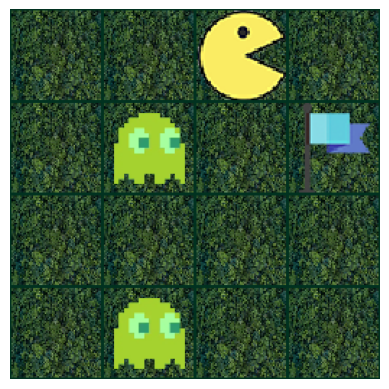

Tot reward:0.0


In [5]:
# ---- Random agent plays Pacman Maze ----
import matplotlib.pyplot as plt
import numpy as np
import time

from IPython.display import clear_output
from NIAC_Project.pacman.arena import AvoidingArena

env = AvoidingArena(render_mode="rgb_array", grid_dim=(4,4), max_num_moves=10, num_enemies=3)
env.reset()

tot_reward = 0
end_episode = False

while not end_episode:
    action = np.random.randint(0, 4)
    observation, reward, terminated, truncated, info = env.step(action)
    tot_reward += reward

    clear_output(wait=True)
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()
    time.sleep(.5)

    end_episode = terminated or truncated

env.close()
print(f"Tot reward:{tot_reward}")

---
## Train & test DQNS Agent

In [8]:
%%bash
source activate niac
python3

import logging
import os
import sys
import torch
import warnings

from NIAC_Project.agents.dqns_agent import DQNSAgent as Agent
from NIAC_Project.pacman.arena import AvoidingArena


# temporary folder for Pygame
os.environ['XDG_RUNTIME_DIR'] = "/tmp/runtime-dir"

# set device CPU or GPU
DEVICE = torch.device(f"cuda:{torch.cuda.current_device()}") if torch.cuda.is_available() else "cpu"
torch.set_default_device(DEVICE)

# set warning and logger
warnings.filterwarnings("ignore", category=RuntimeWarning)
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(name)s:%(funcName)s - %(message)s", force=True)
for name in logging.root.manager.loggerDict:
        if name.startswith("NIAC_Project"):
            logging.getLogger(name).setLevel(logging.WARNING)


print(f"""
-----
    Current Python version: {sys.version}
    Current Pytorc device: {torch.cuda.get_device_name(DEVICE) if torch.cuda.is_available() else 'CPU'}
-----
""")


arena = AvoidingArena(render_mode="rgb_array", grid_dim=(5, 5), max_num_moves=30, num_enemies=4, cell_size=64)
arena.reset()

agent = Agent(arena, batch_size=24, bayesian_net=True, n_samples=5)
agent.train(num_episodes=32, num_epochs=3)

agent.save_model("/content/NIAC_Project/policynet_weights/model_weights_gpu_30-32-3.pth")

quit()


-----
    Current Python version: 3.10.17 | packaged by conda-forge | (main, Apr 10 2025, 22:19:12) [GCC 13.3.0]
    Current Pytorc device: Tesla T4
-----



[Train Epoch 1] Avg Loss: 0.007000194862484932, Success: 7/32 (21.88%): 100%|██████████| 32/32 [02:55<00:00,  5.49s/it]
[Test Epoch 1] Success 5/32 (15.62%): 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]
[Train Epoch 2] Avg Loss: 0.009512071497738361, Success: 4/32 (12.50%): 100%|██████████| 32/32 [02:49<00:00,  5.28s/it]
[Test Epoch 2] Success 4/32 (12.50%): 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]
[Train Epoch 3] Avg Loss: 0.008702803403139114, Success: 9/32 (28.12%): 100%|██████████| 32/32 [03:51<00:00,  7.23s/it]
[Test Epoch 3] Success 6/32 (18.75%): 100%|██████████| 32/32 [00:05<00:00,  5.69it/s]


---
## Extras

In [25]:
#---- Train and test the original agent by Scallop ----
#!git clone https://github.com/scallop-lang/scallop.git

%%bash
source activate niac
python3 /content/scallop/experiments/pacman_maze/run.py --seed 42 --num-epochs 3 --num-train-episodes 32 --num-test-episodes 32 --target-update 8

[Train Epoch 1] Avg Loss: 0.01147414743900299, Success: 11/32 (34.38%): 100%|██████████| 32/32 [04:20<00:00,  8.14s/it]
[Test Epoch 1] Success 3/32 (9.38%): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
[Train Epoch 2] Avg Loss: 0.008965174667537212, Success: 8/32 (25.00%): 100%|██████████| 32/32 [03:45<00:00,  7.04s/it]
[Test Epoch 2] Success 3/32 (9.38%): 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
[Train Epoch 3] Avg Loss: 0.01451109815388918, Success: 7/32 (21.88%): 100%|██████████| 32/32 [03:15<00:00,  6.11s/it]
[Test Epoch 3] Success 0/32 (0.00%): 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


In [9]:
# ---- Modified logic comp. to include different rewards ----
%%bash
source activate niac
python3

import scallopy
import torch
from enum import Enum


# action space
class ACTION(Enum):
    RIGHT = 0
    UP = 1
    LEFT = 2
    DOWN = 3

# possible rewards
rewards = {
    "default": -1.0,
    "on_success": 5.0,
    "on_failure": -5.0,
}

# grid size
X, Y = 3, 3
# max number of moves (L) and min reward (R)
L, R = 3, -100.

# list of all the nodes
nodes = [(i,j) for i in range(X) for j in range(Y)]

# input data from the neural component
agent_p = torch.zeros(X, Y)
target_p = torch.zeros(X, Y)
enemy_p  = torch.zeros(X, Y)
empty_p = torch.zeros(X, Y)

agent_p[1, 0] = 1.0
target_p[2, 2] = 1.0
enemy_p[1, 1] = 1.0
empty_p = torch.ones(X, Y) - (target_p + enemy_p)

# compute expected reward per cell
expected_rewards = rewards["on_success"] * target_p + rewards["on_failure"] * enemy_p + rewards["default"] * empty_p

# print the expected rewards
print("Grid expected rewards:")
print(expected_rewards, "\n")


# base context
ctx = scallopy.ScallopContext(provenance='difftopkproofs')
ctx.add_relation("actor", (int, int))
ctx.add_relation("target", (int, int))
ctx.add_relation("node", (int, int, float))

ctx.add_facts("actor", [(agent_p[node], node) for node in nodes])
ctx.add_facts("target", [(target_p[node], node) for node in nodes])
ctx.add_facts(
    "node",
    [(1.0, (node + (expected_rewards[node],))) for node in nodes],
)

# basic connectivity
ctx.add_rule(f"edge(x, y, xp, y, {ACTION.RIGHT.value}) = node(x, y, _) and node(xp, y, _) and xp == x + 1")
ctx.add_rule(f"edge(x, y, x, yp, {ACTION.UP.value})    = node(x, y, _) and node(x, yp, _) and yp == y + 1")
ctx.add_rule(f"edge(x, y, xp, y, {ACTION.LEFT.value})  = node(x, y, _) and node(xp, y, _) and xp == x - 1")
ctx.add_rule(f"edge(x, y, x, yp, {ACTION.DOWN.value})  = node(x, y, _) and node(x, yp, _) and yp == y - 1")

# path for connectivity
ctx.add_rule(f"path(x, y, x, y, 1, r) = node(x, y, r)") # path(node_i, node_j, num_moves, reward)
ctx.add_rule(f"path(x, y, xp, yp, 1, r) = edge(x, y, xp, yp, _) and node(xp, yp, r)")
ctx.add_rule(f"path(x, y, xpp, ypp, {L}, {R}) = node(x, y, _) and node(xpp, ypp, _) and $abs(x - xpp) + $abs(y - ypp) > 1")
ctx.add_rule(f"path(x, y, xpp, ypp, l + 1, rp + rn) = path(x, y, xp, yp, l, rp) and edge(xp, yp, xpp, ypp, _) and node(xpp, ypp, rn) and path(x, y, xpp, ypp, _, r) and r < rp + rn and l + 1 <= {L}")


# clone and run base context
ctx1 = ctx.clone()
ctx1.run()


# list of all possible paths in max L moves
paths = ctx1.relation("path")

# find best path between each pair of nodes
best_paths = dict()
for path in paths:
    p = path[1]
    if p[:4] not in best_paths or best_paths[p[:4]] < p[5]:
        best_paths[p[:4]] = p[5]

# print best paths
print(f"Best paths (node_ix, node_iy, node_jx, node_jy: reward):\n   {best_paths}")


# clone and run context 2
ctx2 = ctx.clone()
ctx2.add_relation("best_path", (int, int, int, int, float)) # best_path(node_i, node_j, reward)

ctx2.add_facts(
    "best_path",
    [(1.0, k + (v,)) for k, v in best_paths.items()]
)

# next action and next position
ctx2.add_rule("next_position(xp, yp, a, r) = actor(x, y) and edge(x, y, xp, yp, a) and node(xp, yp, r)")
ctx2.add_rule("next_action(a) = next_position(x, y, a, _) and best_path(x, y, gx, gy, _) and target(gx, gy)")
ctx2.run()


# print final results
print(f"Next position (node_x, node_y, action, reward):\n   {list(ctx2.relation('next_position'))}")
print(f"Next action:\n   {list(ctx2.relation('next_action'))}")

quit()

Grid expected rewards:
tensor([[-1., -1., -1.],
        [-1., -5., -1.],
        [-1., -1.,  5.]]) 

Best paths (node_ix, node_iy, node_jx, node_jy: reward):
   {(0, 0, 0, 0): -1.0, (0, 0, 0, 1): -1.0, (0, 0, 0, 2): -2.0, (0, 0, 1, 0): -1.0, (0, 0, 1, 1): -6.0, (0, 0, 1, 2): -3.0, (0, 0, 2, 0): -2.0, (0, 0, 2, 1): -3.0, (0, 0, 2, 2): -100.0, (0, 1, 0, 0): -1.0, (0, 1, 0, 1): -1.0, (0, 1, 0, 2): -1.0, (0, 1, 1, 0): -2.0, (0, 1, 1, 1): -5.0, (0, 1, 1, 2): -2.0, (0, 1, 2, 0): -3.0, (0, 1, 2, 1): -6.0, (0, 1, 2, 2): 3.0, (0, 2, 0, 0): -2.0, (0, 2, 0, 1): -1.0, (0, 2, 0, 2): -1.0, (0, 2, 1, 0): -3.0, (0, 2, 1, 1): -6.0, (0, 2, 1, 2): 3.0, (0, 2, 2, 0): -100.0, (0, 2, 2, 1): 3.0, (0, 2, 2, 2): 4.0, (1, 0, 0, 0): -1.0, (1, 0, 0, 1): -2.0, (1, 0, 0, 2): -3.0, (1, 0, 1, 0): -1.0, (1, 0, 1, 1): -5.0, (1, 0, 1, 2): -6.0, (1, 0, 2, 0): -1.0, (1, 0, 2, 1): -2.0, (1, 0, 2, 2): 3.0, (1, 1, 0, 0): -2.0, (1, 1, 0, 1): -1.0, (1, 1, 0, 2): -2.0, (1, 1, 1, 0): -1.0, (1, 1, 1, 1): -5.0, (1, 1, 1, 2): 3.0, 

In [ ]:
# ---- Custom provenance ----
class MyProvenance(scallopy.provenance.ScallopProvenance):
    def __init__(self, min :float, max :float):
        super(MyProvenance, self).__init__()
        self.min = min
        self.max = max
        return

    def name(self):
        return "custom-provenance"

    def zero(self):
        return self.min

    def one(self):
        return self.max

    def add(self, t1, t2):
        raise Exception("Not implemented")

    def mult(self, t1, t2):
        return torch.clip(t1 + t2, min=self.min, max=self.max)

    def negate(self, t):
        return torch.clip(-t, min=self.min, max=self.max)

    def saturated(self, t1, t2):
        return bool(t1 > t2)